In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

In [2]:
# Dirs
data_dir = r'/home/disk/sipn/nicway/data/obs/NSIDC_0081/native/*.bin'
all_files = sorted(glob.glob(data_dir))
out_dir = '/home/disk/sipn/nicway/data/obs/NSIDC_0081/sipn_nc'
out_nc = 'NSIDC_0081.nc'

In [3]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

In [4]:
def parse_date(str1):
    date1 = str1.split('_')[1]
    yyyy = int(date1[0:4])
    mm = int(date1[4:6])
    dd = int(date1[6:8])
    return datetime.datetime(yyyy,mm,dd)

In [5]:
def read_binary(cfile, x, y):
    n_rows=448
    n_cols=304
    with open(cfile, 'rb') as fr:
        hdr = fr.read(300) 
        ice = np.fromfile(fr, dtype=np.uint8)
    ice = ice.reshape(n_rows, n_cols)
    ice = ice / 250. 
    da_sic = xr.DataArray(ice, coords={'x': x, 'y': y}, dims=('y', 'x'))
    # Add date
    da_sic.coords['time'] = parse_date(os.path.basename(cfile))
    # Mask out non-sic
    da_sic = da_sic.where(da_sic<=1)
    return da_sic

In [6]:
# Get info about target grid
flat = r'/home/disk/sipn/nicway/data/grids/psn25lats_v3.dat'
flon = r'/home/disk/sipn/nicway/data/grids/psn25lons_v3.dat'
NY=304
NX=448
def readBinFile(f, nx, ny):
    with open(f, 'rb') as fid:
        data_array = np.fromfile(f, np.int32)*1e-5
    return data_array.reshape((nx,ny))
lat = readBinFile(flat, NX, NY).T
lon = readBinFile(flon, NX, NY).T
ds_lat_lon = xr.Dataset({'lat': (['x', 'y'],  lat), 'lon': (['x', 'y'], lon)})

In [7]:
# Define coords
dx = dy = 25000
x = np.arange(-3850000, +3750000, +dx)
y = np.arange(+5850000, -5350000, -dy)


In [8]:
# Loop through each binary file and read into a Dataarray
da_l = []
for cf in all_files:
    da_l.append(read_binary(cf, x, y))
ds_sic = xr.concat(da_l, dim='time')

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):


In [9]:
# Add lat and lon dimensions
ds_sic.coords['lat'] = ds_lat_lon.lat
ds_sic.coords['lon'] = ds_lat_lon.lon

In [10]:
# Save to netcdf file
ds_sic.to_netcdf(os.path.join(out_dir,out_nc))

In [11]:
# Formating
ds_sic.name = 'sic'

/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/core/dtypes.py:23: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(dtype, float):
/home/disk/sipn/nicway/anaconda3/envs/xesmf/lib/python3.6/site-packages/xarray/plot/utils.py:51: FutureWarning: 'pandas.tseries.converter.register' has been moved and renamed to 'pandas.plotting.register_matplotlib_converters'. 
  converter.register()


Text(0,0.5,'Millions of square km')

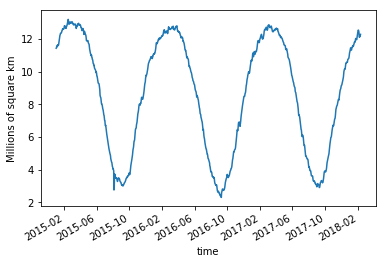

In [12]:
# Mean over time
(ds_sic.where(ds_sic>=0.15).sum(dim='x').sum(dim='y')*(25*25)/(10**6)).plot()
plt.ylabel('Millions of square km')

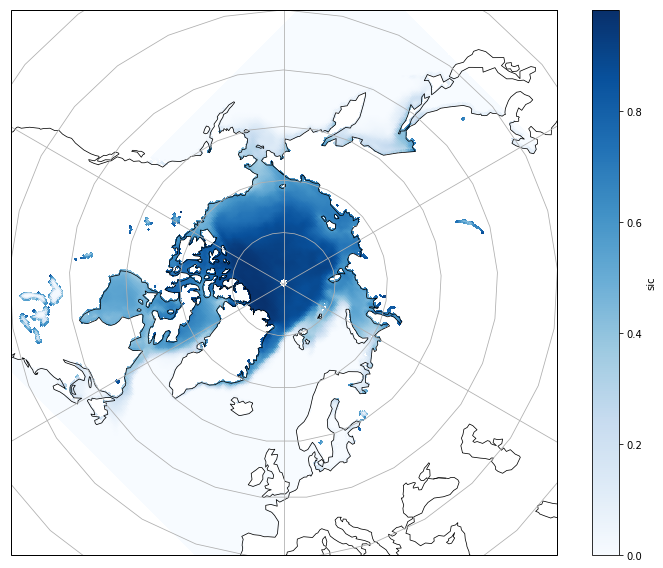

In [13]:
# Plot mean SIC
plt.figure(figsize=(10,8));
ax1 = plt.axes(projection=ccrs.NorthPolarStereo(central_longitude=0))

kw = dict(central_latitude=90, central_longitude=-45, true_scale_latitude=70)
ds_sic.mean(dim='time').plot.pcolormesh(ax=ax1, x='x', y='y', 
                                     transform=ccrs.Stereographic(**kw),
                                     cmap=plt.cm.Blues)
# Add coastlines and meridians/parallels 
ax1.coastlines(linewidth=0.75, color='black', resolution='110m')
ax1.gridlines(crs=ccrs.PlateCarree(), linestyle='-')
ax1.set_extent([-180, 180, 40, 90], crs=ccrs.PlateCarree())
plt.tight_layout()